# Lesson 1

### The spelled-out intro to neural networks and backpropagation: building micrograd

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 -4*x + 5

In [3]:
f(3.0)

20.0

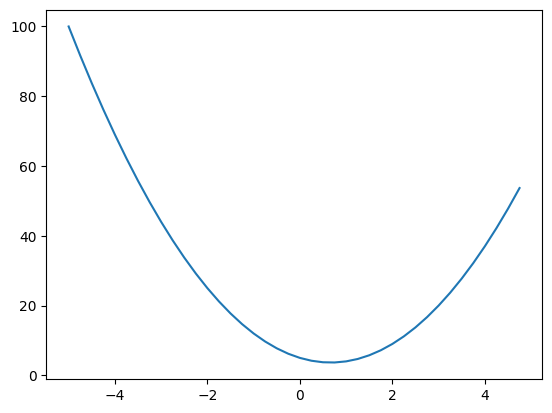

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs,ys)
plt.show()

In [5]:
# Derivative

h = 0.0001
x = 3.0
print(f(x),f(x+h))

20.0 20.001400030000006


## Derivative

In [6]:
slope = (f(x+h) - f(x))/h
slope

14.000300000063248

In [7]:
# Now I expect negative derivative for -3.0

x = -3.0
(f(x+h) - f(x))/h

-21.999700000066014

Let's get more complex, a,b,c are inputs and d is output.
I want to know the derivative of d with respect to a,b,c


In [8]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d

4.0

In [9]:
h = 0.00001

# Inputs
a = 2.0
b = -3.0
c = 10.0

# Output
d1 = a*b + c
a += h
d2 = a*b + c

print(f'd1 is {d1}, d2 is {d2}, slope: {(d2-d1)/h}')
# d1 is 4.0, d2 is 3.9999699999999994, slope: -3.000000000064062

d1 is 4.0, d2 is 3.9999699999999994, slope: -3.000000000064062


Why the derivative is 3? Because d derivate wrt a is b (that is -3)

Now you can see d derivate wrt b is a (that is 2)

In [10]:
# Output
d1 = a*b + c
b += h
d2 = a*b + c

print(f'd1 is {d1}, d2 is {d2}, slope: {(d2-d1)/h}')
# d1 is 3.9999699999999994, d2 is 3.9999900000999995, slope: 2.00001000001393

d1 is 3.9999699999999994, d2 is 3.9999900000999995, slope: 2.00001000001393


C slope will be 1

In [11]:
# Output
d1 = a*b + c
c += h
d2 = a*b + c

print(f'd1 is {d1}, d2 is {d2}, slope: {(d2-d1)/h}')
# d1 is 3.9999900000999995, d2 is 4.000000000099999, slope: 0.9999999999621422

d1 is 3.9999900000999995, d2 is 4.000000000099999, slope: 0.9999999999621422


In [12]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # Gradient
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out 
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [13]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b ; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

Value(data=-8.0)

In [14]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [15]:
d._op

'+'

In [16]:
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={'rankdir': 'LR'}) # LR = Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad ), shape="record")
        
        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)

            # and connect this node to it
            dot.edge(uid + n._op, uid) 
    
    for n1,n2 in edges:

        # Connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot
 

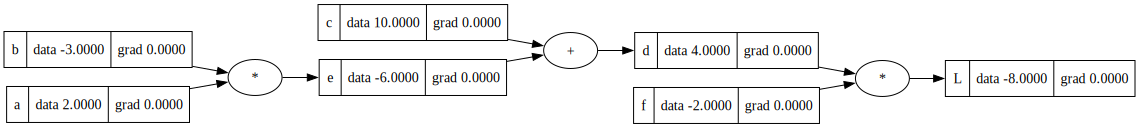

In [17]:
draw_dot(L)

In [18]:
L = d * f

#dL/dd = ?  = f

'''
(f(x+h) - f(x))/h
((d+h)*f - d*f)/h
(d*f + h*f - d*f) / h
f
'''

'\n(f(x+h) - f(x))/h\n((d+h)*f - d*f)/h\n(d*f + h*f - d*f) / h\nf\n'

In [19]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0

In [20]:
# increasing the leaf node (where we have control) to augment the value of L (we are moving in the direction of the gradient)

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.84


In [21]:
def lol():
    
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b ; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data


    a = Value(2.0 , label='a')
    a.data += h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b ; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

In [22]:
lol()

6.000000000000227


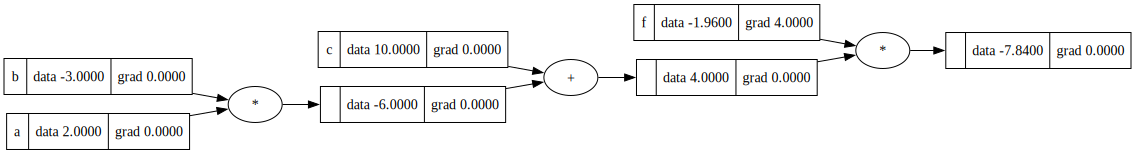

In [23]:
draw_dot(L)

In [24]:
'''dd / dc ? 

d = c + e

(f(x+h) - f(x) )/ h

((c + h + e) - (c +e) ) /h

(c + h + e - c - e) / h

h/h = 1.0
'''

'dd / dc ? \n\nd = c + e\n\n(f(x+h) - f(x) )/ h\n\n((c + h + e) - (c +e) ) /h\n\n(c + h + e - c - e) / h\n\nh/h = 1.0\n'

In [25]:
# dd/dc  = 1.0
# dd/de = 1.0
# d = c + e

# KNOW 
#dL/dd
#dd/dc

# WANT
# dL/dc = dL/dd * (dd/dc)

In [26]:
c.grad = -2.0
e.grad = -2.0

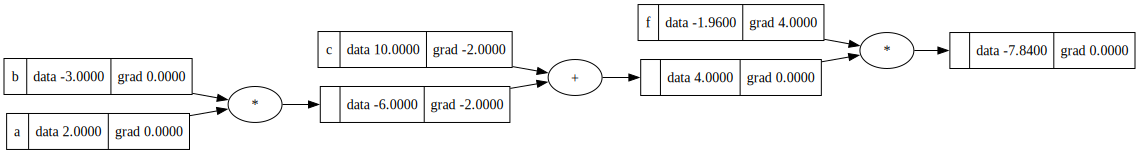

In [27]:
draw_dot(L)

In [28]:
# Same thing for b and a 

# dL/de = -2.0
#WANT
#dL/da = dL/de * de/da

# de/da = b

# dL/da = (-2.0) * (-3.0) = 6.0

# dL/db = (-2.0) * (2.0) = -4.0

In [29]:
b.grad = -4.0
a.grad = 6.0

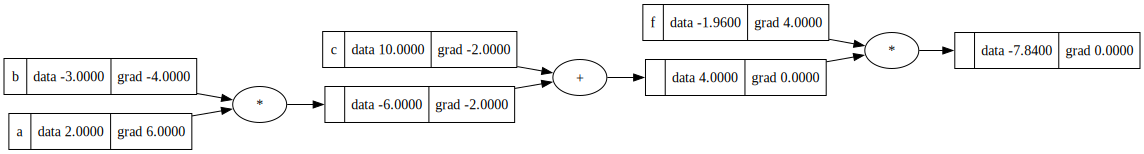

In [30]:
draw_dot(L)

# Neuron

## Activation function

<img src="https://miro.medium.com/v2/resize:fit:816/0*_jEHA-jE-h_dZiVZ.png"/>


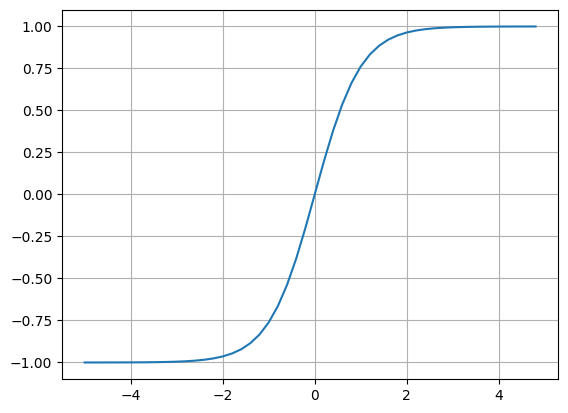

In [31]:
plt.plot(np.arange(-5,5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

In [32]:
# Inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# Weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.8813735870195432, label="b")


# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b; n.label = "n"

o = n.tanh(); o.label="o"


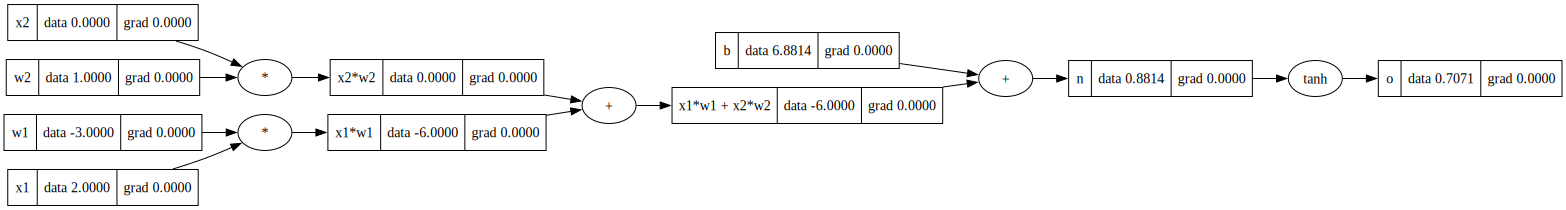

In [33]:
draw_dot(o)

In [34]:
o.grad = 1.0

In [35]:
# Calculating the derivative
# do/dn = 1 - tanh^2(n)

# = 1 - o^2

In [36]:
1 - o.data**2 #0.4999999999999999

0.4999999999999999

In [37]:
n.grad = 0.5

In [38]:
# Any + --> means progagate the gradient backward
x1w1x2w2.grad = 0.5
b.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

In [39]:
x2.grad = w2.data + x2w2.grad
w2.grad = x2.data + x2w2.grad

In [40]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

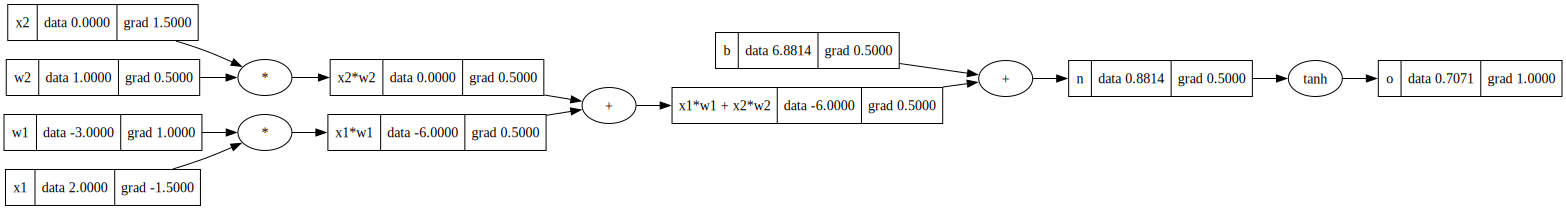

In [41]:
draw_dot(o)

In [42]:
# Inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# Weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.8813735870195432, label="b")


# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b; n.label = "n"

o = n.tanh(); o.label="o"


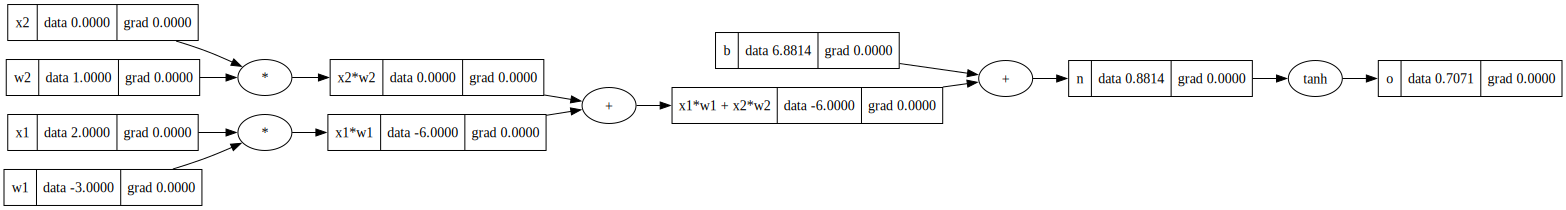

In [43]:
draw_dot(o)

In [44]:
o.grad = 1.0
o._backward()

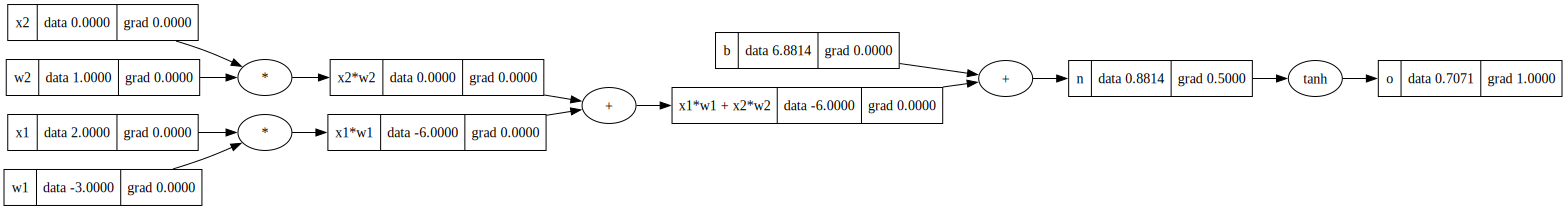

In [45]:
draw_dot(o)

In [46]:
n._backward()

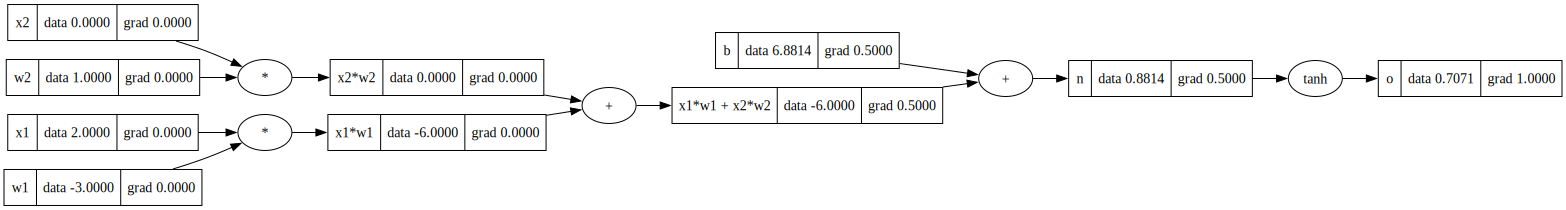

In [47]:
draw_dot(o)

In [48]:
b._backward()

In [49]:
x1w1x2w2._backward()

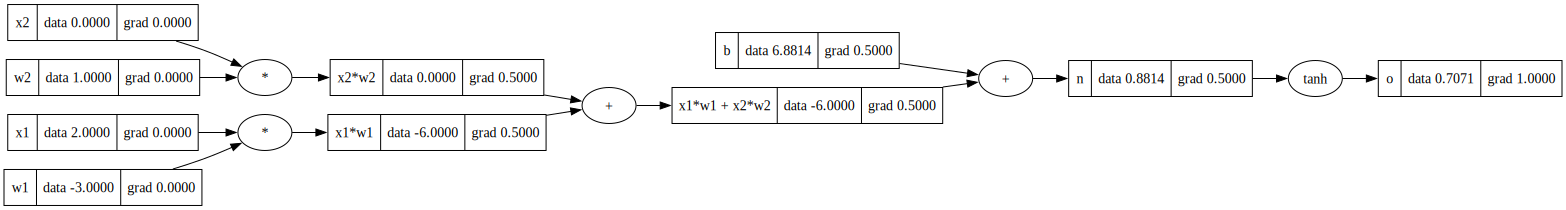

In [50]:
draw_dot(o)

In [51]:
x1w1x2w2._backward()

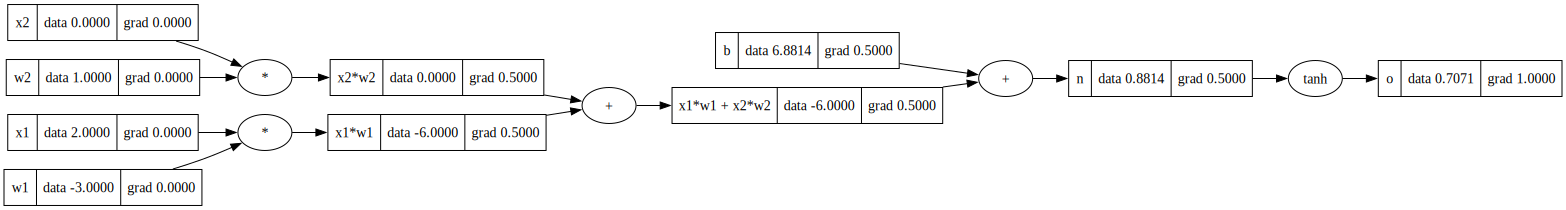

In [52]:
draw_dot(o)

In [53]:
x1w1._backward()
x2w2._backward()

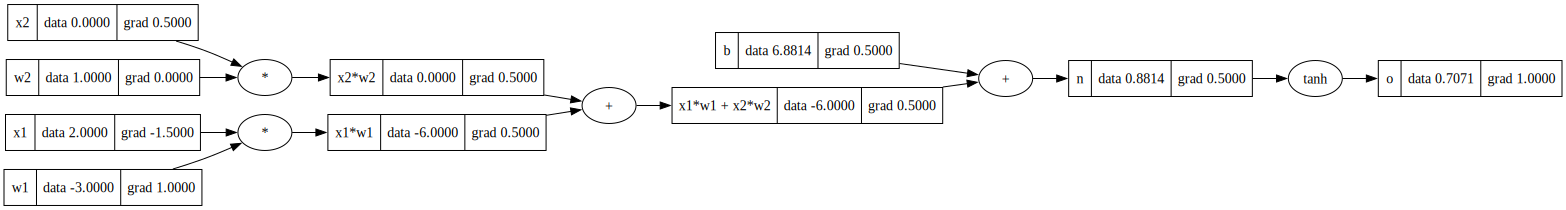

In [54]:
draw_dot(o)

## Topological sort

In [55]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [56]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

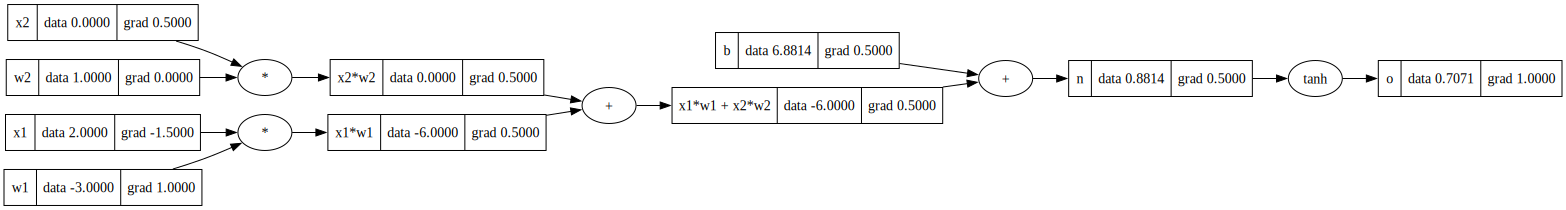

In [57]:
draw_dot(o)

In [58]:
o.backward()

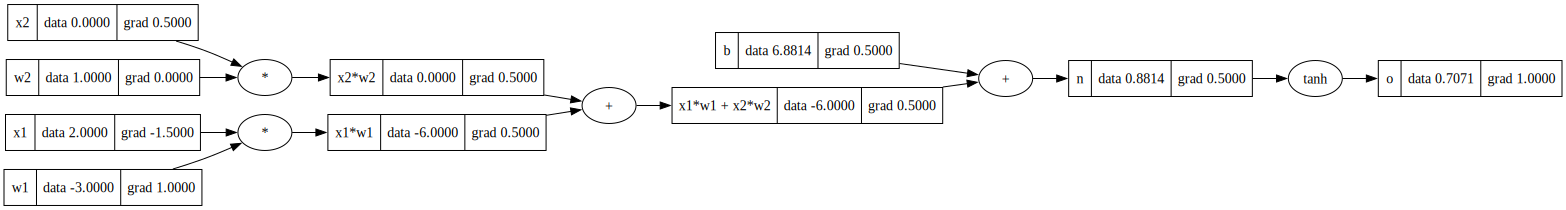

In [59]:
draw_dot(o)

## Fixing a backdrop bug when one node is used multiple times

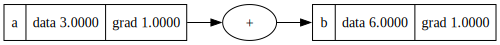

In [60]:
a = Value(3.0, label='a')
b = a + a ; b.label='b'
b.backward()
draw_dot(b)

In [61]:
# The derivative has to be 2 (1+1)
# But is 1. What's happening?

'''
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    
'''

# Nella funzione _backward implementata in __add__ quando passiamo a sia a self che ad other
# Nelle riga other.grad stiamo andando a sovrascrivere sul valore di a stesso

"\n    def __add__(self, other):\n        out = Value(self.data + other.data, (self, other), '+')\n        \n        def _backward():\n            self.grad = 1.0 * out.grad\n            other.grad = 1.0 * out.grad\n        out._backward = _backward\n        return out\n    \n"

In [62]:
# Un altro caso in cui dà problemi --> un nodo usato in più casi

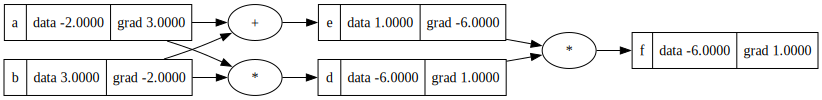

In [63]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label='d'
e = a + b ; e.label='e'
f = d * e ; f.label='f'

f.backward()

draw_dot(f)

# Soluzione: Multivariate case della chain rule

# Basta fare += invece che =

In [111]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # Gradient
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
     
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out 
    
    # For 2 * a case (It find for a method that know how to multiply the swapped operands (a * 2)
    # and this method is: __mul__ and it uses it
    def __rmul__(self, other):
        return self * other
    
    def __neg__(self): #-self
        return self * -1

    def __sub__ (self, other): # self - other
        return self + (-other)

    def __rsub__ (self, other): # self - other
        return self + (-other)
    
    def __truediv__(self, other): # self / other
        return self * other **-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'Only supporting int OR float powers for now'
        out = Value(self.data** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

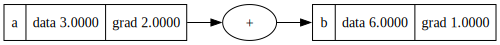

In [65]:
a = Value(3.0, label='a')
b = a + a ; b.label='b'
b.backward()
draw_dot(b)

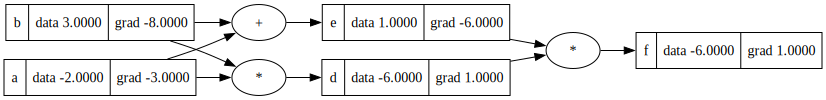

In [66]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label='d'
e = a + b ; e.label='e'
f = d * e ; f.label='f'

f.backward()

draw_dot(f)

In [97]:
a = Value(2.0)
b = Value(4.0)
5 - b 

Value(data=-1.0)

In [98]:
o.backward()

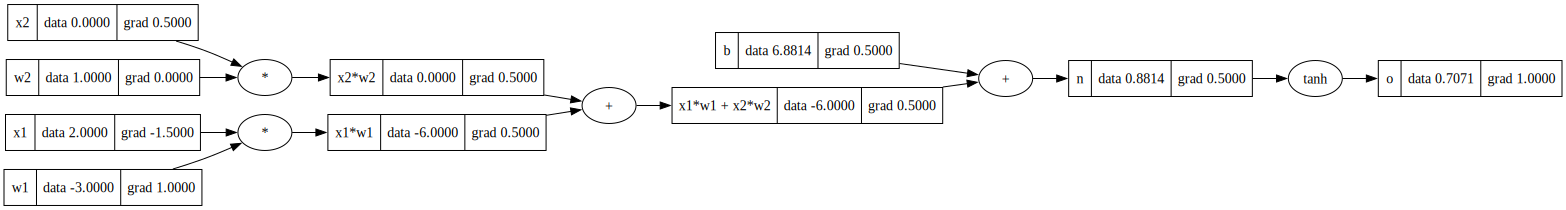

In [99]:
draw_dot(o)

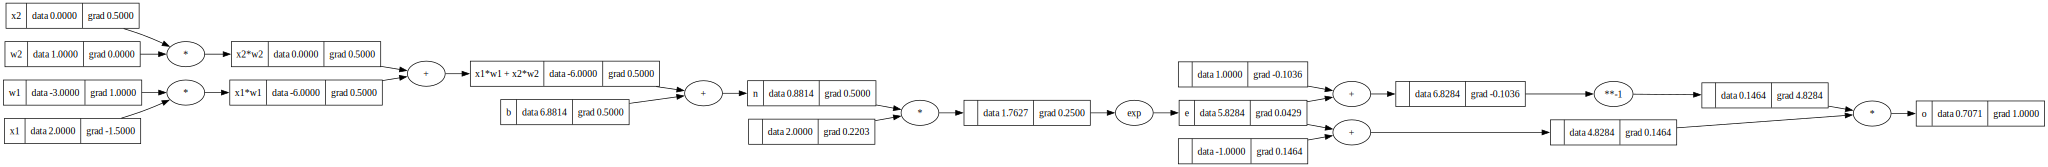

In [114]:
# Inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# Weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.8813735870195432, label="b")


# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b; n.label = "n"
# ------
e = (2*n).exp(); e.label='e'
o = (e-1) / (e+1); o.label="o" 
# ------
o.backward()
draw_dot(o)
# The result is not changed

# PyTorch

It works very similar

In [141]:
import torch 
import random


In [118]:
x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b                           
o = torch.tanh(n)                               

print(o.data.item())
o.backward()

0.7071066904050358


In [129]:
torch.Tensor([2.0])

tensor([2.])

In [188]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w*x + b
        act = sum ( (wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        



# MLP Multilayer Perceptron

![image](https://lh4.googleusercontent.com/nbSaf2vsNkTm6u6oEMqAzJw8Ksy94byIzTEjHXMki_31kJ9yMz3isaxr4zFdq99wFcGC_3iOeUhSaWhl7TzMEGEHLeWyBev5W49ZElOBppkAa5_ulG0kT-fghwNCd9jUcClSdMlX8THLt8nbvQ)

In [189]:
x = [2.0, 3.0, -1.0] # Inputs
n = MLP(3, [4, 4, 1]) # (Input neurons, [Hidden Layers neurons and Output layer neurons])

n(x)

Value(data=-0.2691211022962944)

In [190]:
n.parameters()

[Value(data=-0.16967913622300945),
 Value(data=-0.24542414082613284),
 Value(data=-0.16696619082875785),
 Value(data=0.49202815723836313),
 Value(data=0.6187947420573774),
 Value(data=0.3206608181469621),
 Value(data=-0.45013249156453883),
 Value(data=0.831882798852168),
 Value(data=-0.19798870620171005),
 Value(data=0.8291428811415542),
 Value(data=0.8148468528999593),
 Value(data=0.7502475507478603),
 Value(data=-0.41426281453274694),
 Value(data=0.804024513636548),
 Value(data=-0.6768160294304075),
 Value(data=-0.7581967714448588),
 Value(data=0.08334399922580227),
 Value(data=0.846324535627119),
 Value(data=0.7717853318932677),
 Value(data=0.5201589269077953),
 Value(data=0.5647957684255198),
 Value(data=0.37724806268317046),
 Value(data=0.5054114817760285),
 Value(data=0.3825720324333637),
 Value(data=-0.9926368016857836),
 Value(data=-0.9431151472994592),
 Value(data=0.33187854018564367),
 Value(data=-0.2998568445081453),
 Value(data=0.13718604148220814),
 Value(data=0.7548660641

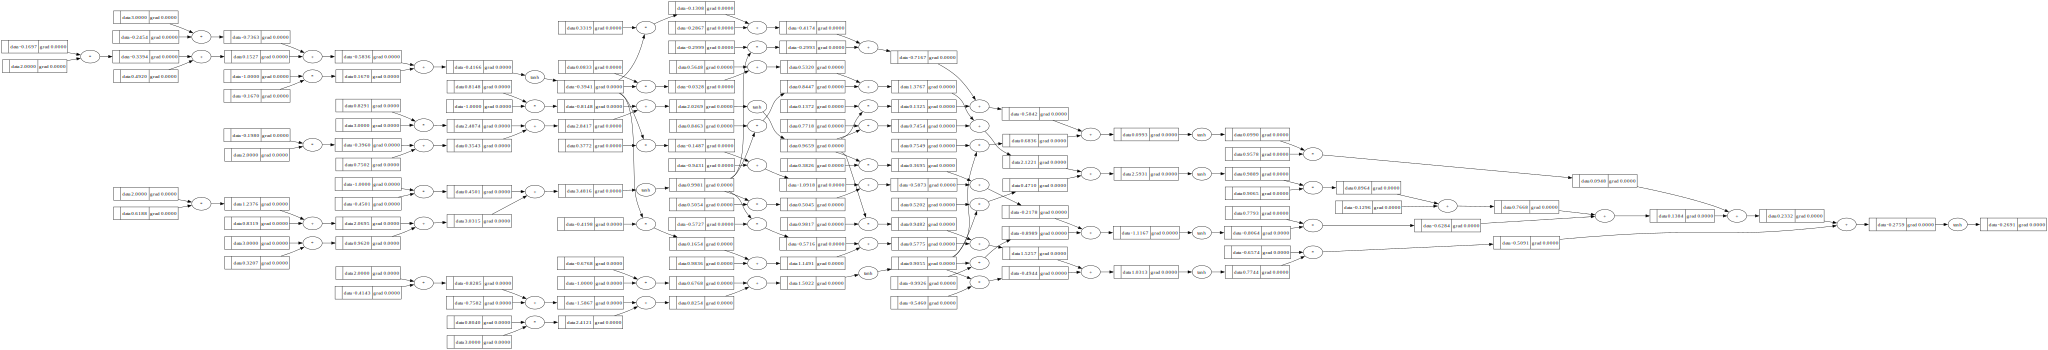

In [191]:
draw_dot(n(x))

In [192]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.2691211022962944),
 Value(data=-0.4176593570123993),
 Value(data=-0.24316661336268128),
 Value(data=-0.16652899835719834)]

In [193]:
loss = sum([(yout - ygt)**2  for ygt, yout in zip(ys, ypred)])
loss

Value(data=3.8833756759061346)

In [194]:
loss.backward()

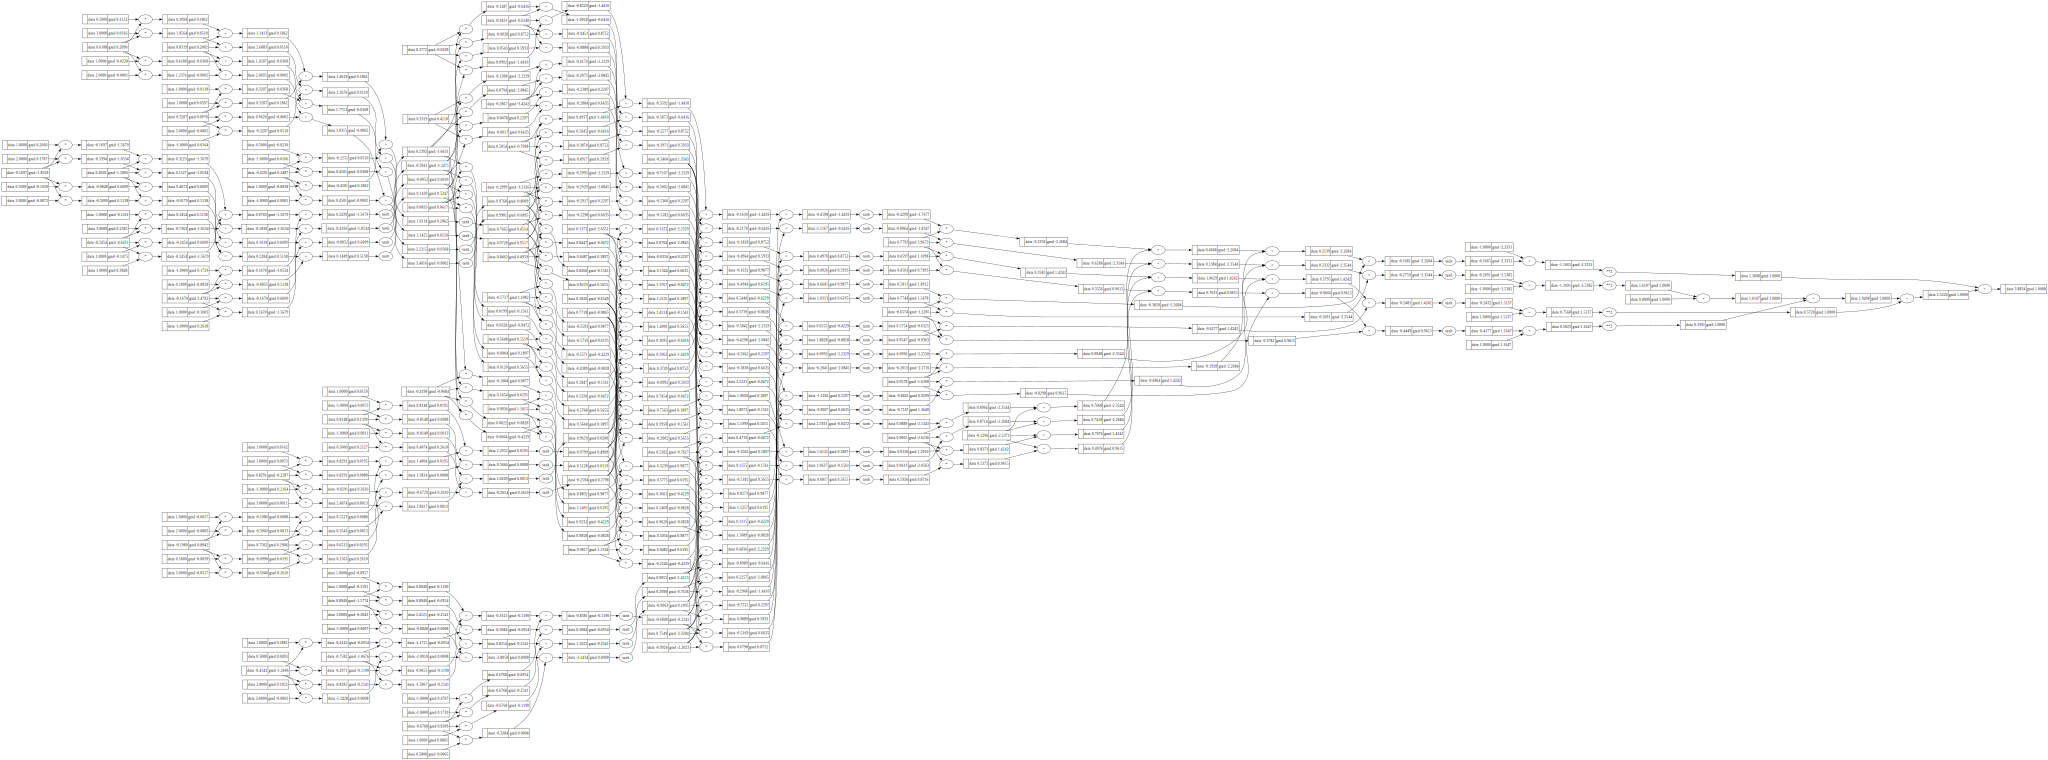

In [195]:
draw_dot(loss)

In [199]:
n.layers[0].neurons[0].w[0].data

-0.1513515799952911

In [200]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [201]:
n.layers[0].neurons[0].w[0].data

-0.13302402376757277

In [204]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [249]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2  for ygt, yout in zip(ys, ypred)])
loss

Value(data=0.00046330599812232845)

In [250]:
loss.backward()

In [251]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [252]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2  for ygt, yout in zip(ys, ypred)])
loss

Value(data=0.000189084260683421)

In [253]:
ypred

[Value(data=0.9945340099035207),
 Value(data=-0.9976672295586886),
 Value(data=-0.9884571361625636),
 Value(data=0.9954692506748709)]

# Create the Gradient Descent loop in function

In [274]:
# Initiazlization
x = [2.0, 3.0, -1.0] # Inputs
n = MLP(3, [4, 4, 1]) # (Input neurons, [Hidden Layers neurons and Output layer neurons])

n(x)

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [275]:
def gradient_descent():
    for k in range(1000):
        # Forward pass
        ypred = [n(x) for x in xs]
        loss = sum([(yout - ygt)**2  for ygt, yout in zip(ys, ypred)])

        # Backward pass
        for p in n.parameters():
            p.grad = 0.0
        loss.backward()

        # Update
        for p in n.parameters():
            p.data += -0.03 * p.grad

        print(k, loss.data)

gradient_descent()

0 5.742153449394095
1 4.561157421836453
2 4.006498199687217
3 3.619202997468183
4 3.25869339737067
5 2.8917256251746233
6 2.516861521549433
7 2.146236426445792
8 1.792078513296431
9 1.4622426849704506
10 1.165078185037997
11 0.9114589906823838
12 0.7086232019859846
13 0.5548766736491796
14 0.4416711421568996
15 0.35877590790345515
16 0.2974769666937706
17 0.25135284774496536
18 0.21594724739034632
19 0.18822325956539349
20 0.16610593165581178
21 0.1481598331421636
22 0.13337525914637408
23 0.12102904017924956
24 0.11059383951574506
25 0.10167845130556918
26 0.09398793974526208
27 0.08729659678330548
28 0.08142929295224544
29 0.0762484074196248
30 0.0716445252029261
31 0.06752971777437848
32 0.06383262208080645
33 0.06049478963166244
34 0.057467944828498194
35 0.05471190264232424
36 0.052192970246898
37 0.04988270793588305
38 0.04775695963493438
39 0.04579508775098982
40 0.043979364366325366
41 0.04229448312397997
42 0.04072716506399371
43 0.03926583817320565
44 0.03790037520214062
45 0

In [277]:
ypred

[Value(data=0.9945340099035207),
 Value(data=-0.9976672295586886),
 Value(data=-0.9884571361625636),
 Value(data=0.9954692506748709)]